Importing required libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time
import collections
import math
import pandas as pd
from tqdm.notebook import tqdm, trange

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# Unpack the dataset zip file
shutil.unpack_archive("/content/drive/MyDrive/Deep Learning/Pediatric Pneumonia.zip", "/content/Datasets/")

In [5]:
batch_size = 32
transform_train = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
   ])

transform_test = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
   ])

In [6]:
data_dir = '/content/Datasets/Pediatric Pneumonia'

train_ds, train_valid_ds = [datasets.ImageFolder(
    os.path.join(data_dir, folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [datasets.ImageFolder(
    os.path.join(data_dir, folder),
    transform=transform_test) for folder in ['valid', 'test']]

In [7]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

In [8]:
means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_ds:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_ds)
stds /= len(train_ds)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([-0.0130,  0.1162,  0.3379])
Calculated stds: tensor([0.9285, 0.9492, 0.9450])


In [9]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

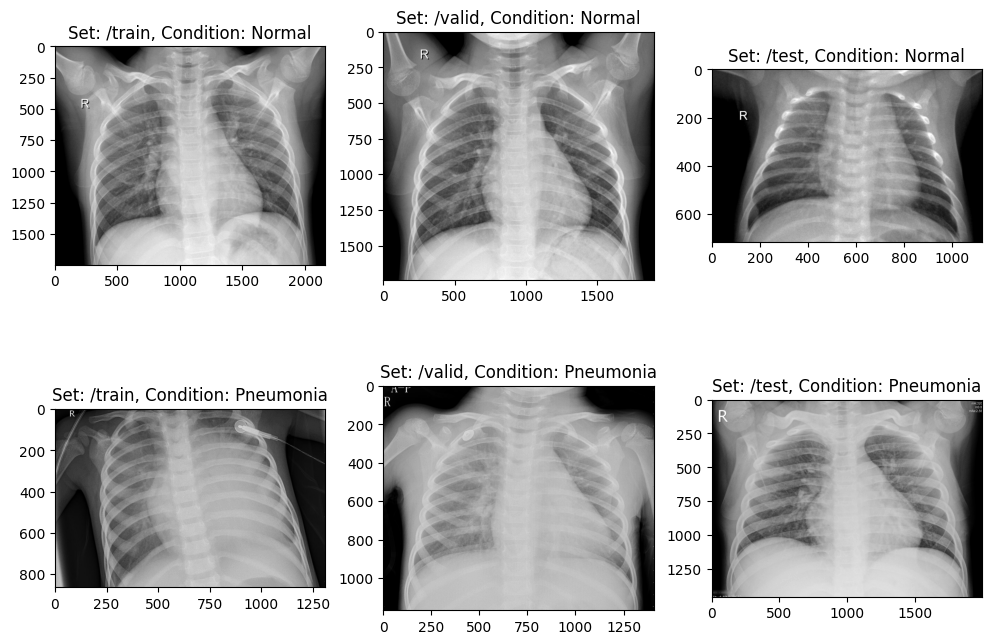

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(10, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['/train', '/valid', '/test']):
    set_path = data_dir+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

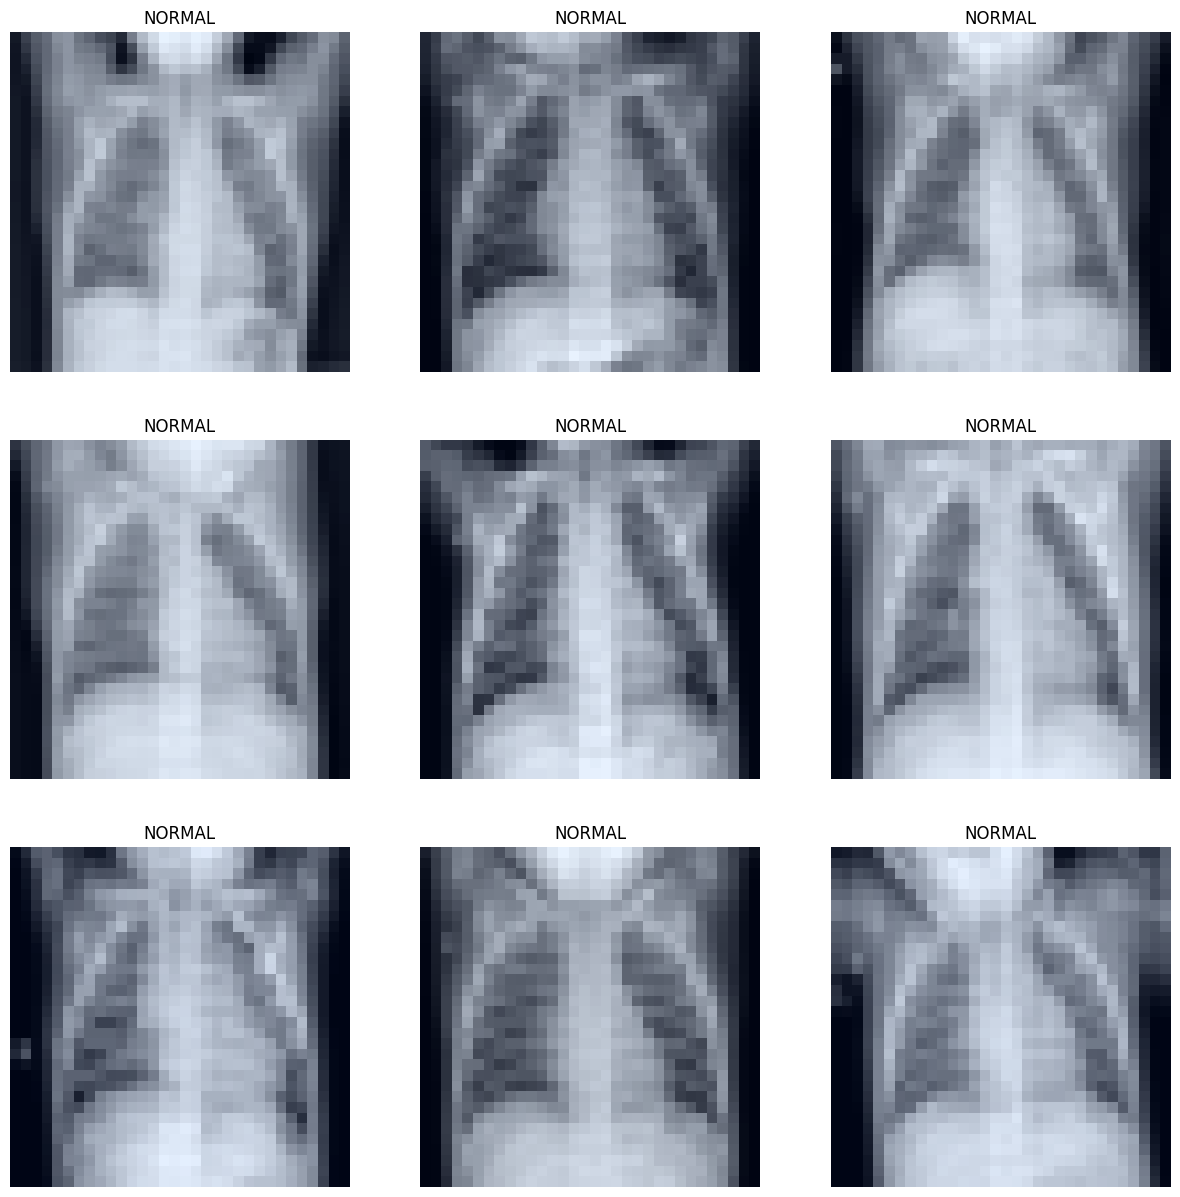

In [11]:
N_IMAGES = 10

images, labels = zip(*[(image, label) for image, label in 
                           [train_ds[i] for i in range(N_IMAGES)]])

classes = train_ds.classes

plot_images(images, labels, classes)

Define the CNN - this example will focus on AlexNet.

In [12]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),  # in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2),  # kernel_size
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

HERE you can adjust the number of classes

In [13]:
OUTPUT_DIM = 2

model = AlexNet(OUTPUT_DIM)

def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

model.apply(initialize_parameters)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

This is to display the number of trainable parameters.

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,239,490 trainable parameters


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

CHOSE_LR = 1e-3

optimizer = optim.Adam(model.parameters(), lr=CHOSE_LR)

In [16]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [17]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [18]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [19]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs



In [20]:
EPOCHS = 15

# keeping-track-of-losses 
train_losses_alexNet = []
valid_losses_alexNet = []
train_accuracy_alexNet = []
valid_accuracy_alexNet = []
best_valid_loss_alexNet = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss_alexNet, train_acc_alexNet = train(model, train_iter, optimizer, criterion, device)
    valid_loss_alexNet, valid_acc_alexNet = evaluate(model, valid_iter, criterion, device)

    train_losses_alexNet.append(train_loss_alexNet)
    valid_losses_alexNet.append(valid_loss_alexNet)
    train_accuracy_alexNet.append(train_acc_alexNet)
    valid_accuracy_alexNet.append(valid_acc_alexNet)

    if valid_loss_alexNet < best_valid_loss_alexNet:
        best_valid_loss_alexNet = valid_loss_alexNet
        torch.save(model.state_dict(), 'best-model-alexNet.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss_alexNet:.3f} | Train Acc: {train_acc_alexNet*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss_alexNet:.3f} |  Val. Acc: {valid_acc_alexNet*100:.2f}%')

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 34s
	Train Loss: 1.084 | Train Acc: 88.19%
	 Val. Loss: 0.246 |  Val. Acc: 92.19%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 28s
	Train Loss: 0.120 | Train Acc: 95.87%
	 Val. Loss: 0.225 |  Val. Acc: 92.88%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 25s
	Train Loss: 0.100 | Train Acc: 96.79%
	 Val. Loss: 0.184 |  Val. Acc: 93.40%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 24s
	Train Loss: 0.092 | Train Acc: 96.72%
	 Val. Loss: 0.157 |  Val. Acc: 96.35%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 1m 25s
	Train Loss: 0.071 | Train Acc: 97.59%
	 Val. Loss: 0.221 |  Val. Acc: 93.75%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 1m 24s
	Train Loss: 0.058 | Train Acc: 97.99%
	 Val. Loss: 0.409 |  Val. Acc: 91.67%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 1m 24s
	Train Loss: 0.048 | Train Acc: 98.42%
	 Val. Loss: 0.250 |  Val. Acc: 91.49%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 25s
	Train Loss: 0.057 | Train Acc: 98.19%
	 Val. Loss: 0.108 |  Val. Acc: 96.01%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 1m 24s
	Train Loss: 0.036 | Train Acc: 98.79%
	 Val. Loss: 0.122 |  Val. Acc: 95.66%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 24s
	Train Loss: 0.033 | Train Acc: 98.82%
	 Val. Loss: 0.260 |  Val. Acc: 94.44%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 1m 26s
	Train Loss: 0.036 | Train Acc: 98.68%
	 Val. Loss: 0.416 |  Val. Acc: 92.19%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 1m 24s
	Train Loss: 0.037 | Train Acc: 98.75%
	 Val. Loss: 0.303 |  Val. Acc: 94.97%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 1m 26s
	Train Loss: 0.023 | Train Acc: 99.20%
	 Val. Loss: 0.564 |  Val. Acc: 91.49%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 1m 26s
	Train Loss: 0.033 | Train Acc: 99.08%
	 Val. Loss: 0.123 |  Val. Acc: 96.53%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 1m 26s
	Train Loss: 0.035 | Train Acc: 98.91%
	 Val. Loss: 0.112 |  Val. Acc: 95.83%


Example code to plot losses.

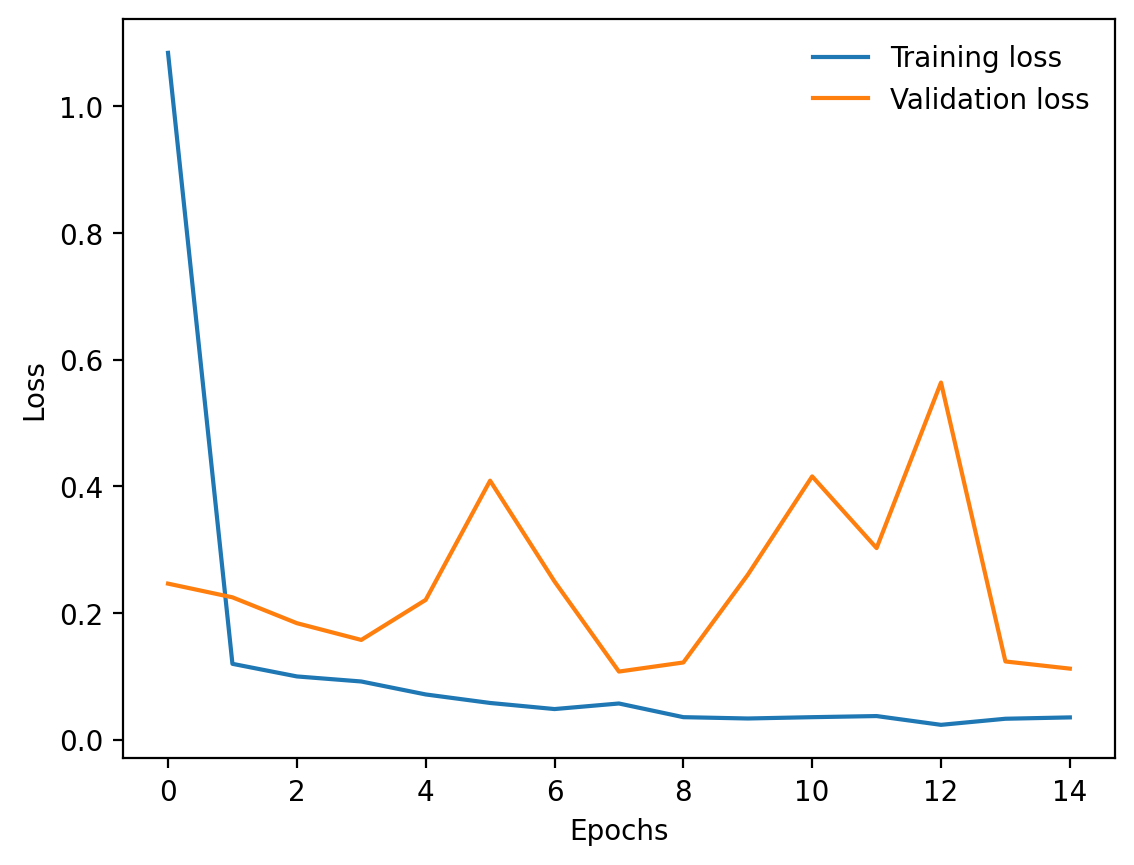

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses_alexNet, label='Training loss')
plt.plot(valid_losses_alexNet, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

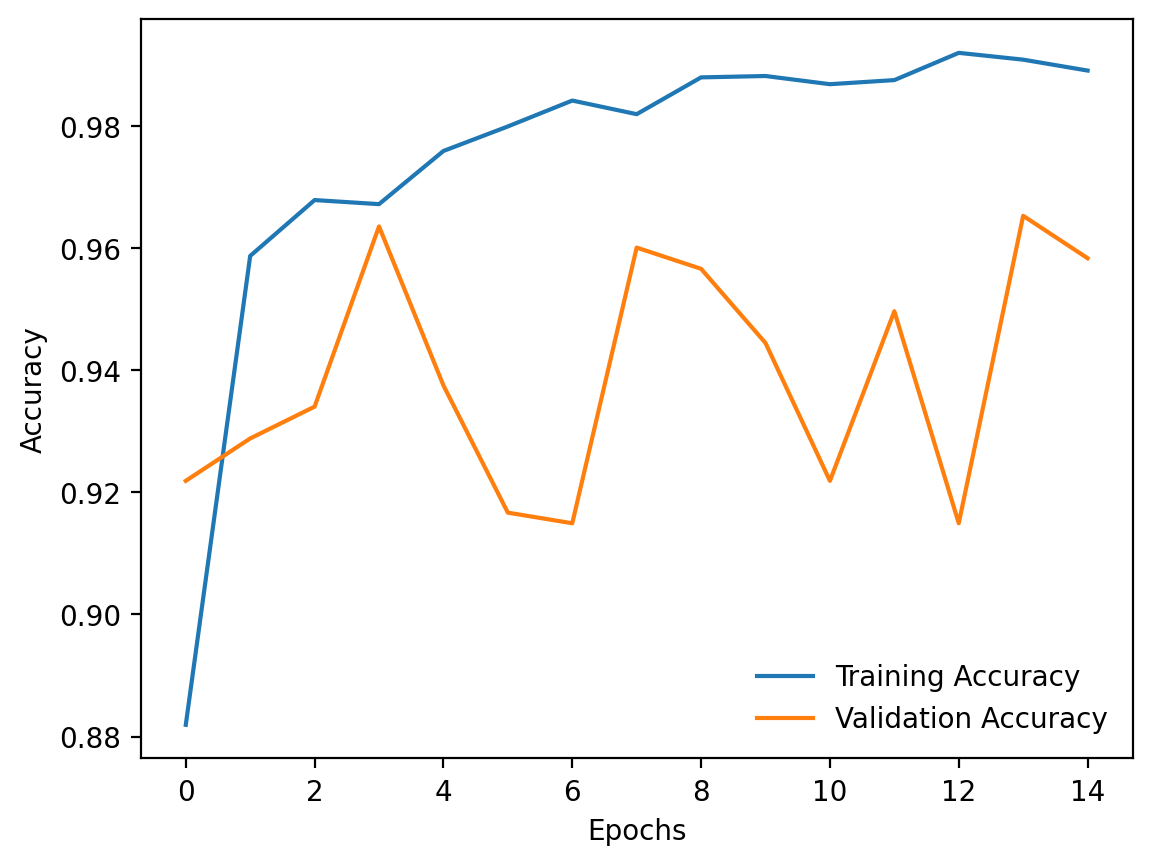

In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_accuracy_alexNet, label='Training Accuracy')
plt.plot(valid_accuracy_alexNet, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(frameon=False)

Loading the best model

In [23]:
model.load_state_dict(torch.load('best-model-alexNet.pt'))

<All keys matched successfully>

In [24]:
images, labels, probs = get_predictions(model, test_iter, device)

In [25]:
plot_images(images, labels, probs)

Output hidden; open in https://colab.research.google.com to view.

Define the CNN - this example will focus on VGG and its variation. DO NOT CHANGE THE CODE IN THESE PARTS. MIT License: Copyright (c) 2018 Ben Trevett.

In [26]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512,
                512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512,
                'M', 512, 512, 512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512,
                512, 512, 'M', 512, 512, 512, 512, 'M']

def get_vgg_layers(config, batch_norm):

    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

HERE you can start to define your model, you can use different vgg for your work. Change the OUTPUT_DIM to the number of classes.

In [27]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)
#print(vgg11_layers)

OUTPUT_DIM = 2

model = VGG(vgg11_layers, OUTPUT_DIM)
#print(model)
pretrained_model = models.vgg11_bn(pretrained=True)
#print(pretrained_model)
IN_FEATURES = pretrained_model.classifier[-1].in_features

final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:11<00:00, 48.3MB/s]


In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 128,780,034 trainable parameters


Setting the hyperparameters and train the model

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

FOUND_LR = 5e-4

params = [
          {'params': model.features.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.classifier.parameters()}
         ]

optimizer = optim.Adam(params, lr=FOUND_LR)

In [30]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [31]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [32]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [33]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [34]:
EPOCHS = 15

# keeping-track-of-losses 
train_losses_vgg = []
valid_losses_vgg = []
train_accuracy_vgg = []
valid_accuracy_vgg = []

best_valid_loss_vgg = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss_vgg, train_acc_vgg = train(model, train_iter, optimizer, criterion, device)
    valid_loss_vgg, valid_acc_vgg = evaluate(model, valid_iter, criterion, device)

    train_losses_vgg.append(train_loss_vgg)
    valid_losses_vgg.append(valid_loss_vgg)
    train_accuracy_vgg.append(train_acc_vgg)
    valid_accuracy_vgg.append(valid_acc_vgg)

    if valid_loss_vgg < best_valid_loss_vgg:
        best_valid_loss_vgg = valid_loss_vgg
        torch.save(model.state_dict(), 'best-model-vgg.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss_vgg:.3f} | Train Acc: {train_acc_vgg*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss_vgg:.3f} |  Val. Acc: {valid_acc_vgg*100:.2f}%')

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 42s
	Train Loss: 0.876 | Train Acc: 90.80%
	 Val. Loss: 0.730 |  Val. Acc: 83.68%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 37s
	Train Loss: 0.099 | Train Acc: 96.92%
	 Val. Loss: 0.111 |  Val. Acc: 95.83%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 34s
	Train Loss: 0.080 | Train Acc: 97.28%
	 Val. Loss: 0.577 |  Val. Acc: 89.24%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 33s
	Train Loss: 0.073 | Train Acc: 97.81%
	 Val. Loss: 0.770 |  Val. Acc: 83.68%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 1m 34s
	Train Loss: 0.041 | Train Acc: 98.79%
	 Val. Loss: 0.262 |  Val. Acc: 92.36%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 1m 34s
	Train Loss: 0.049 | Train Acc: 98.39%
	 Val. Loss: 0.477 |  Val. Acc: 94.10%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 1m 32s
	Train Loss: 0.025 | Train Acc: 99.22%
	 Val. Loss: 0.412 |  Val. Acc: 93.75%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 34s
	Train Loss: 0.024 | Train Acc: 99.26%
	 Val. Loss: 1.183 |  Val. Acc: 90.62%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 1m 33s
	Train Loss: 0.035 | Train Acc: 98.84%
	 Val. Loss: 0.718 |  Val. Acc: 94.10%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 33s
	Train Loss: 0.036 | Train Acc: 98.86%
	 Val. Loss: 0.679 |  Val. Acc: 93.92%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 1m 34s
	Train Loss: 0.017 | Train Acc: 99.73%
	 Val. Loss: 1.026 |  Val. Acc: 92.19%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 1m 32s
	Train Loss: 0.138 | Train Acc: 97.50%
	 Val. Loss: 0.283 |  Val. Acc: 92.53%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 1m 41s
	Train Loss: 0.032 | Train Acc: 99.02%
	 Val. Loss: 0.486 |  Val. Acc: 92.88%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 1m 35s
	Train Loss: 0.018 | Train Acc: 99.31%
	 Val. Loss: 0.305 |  Val. Acc: 94.27%


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 1m 33s
	Train Loss: 0.005 | Train Acc: 99.80%
	 Val. Loss: 0.437 |  Val. Acc: 94.79%


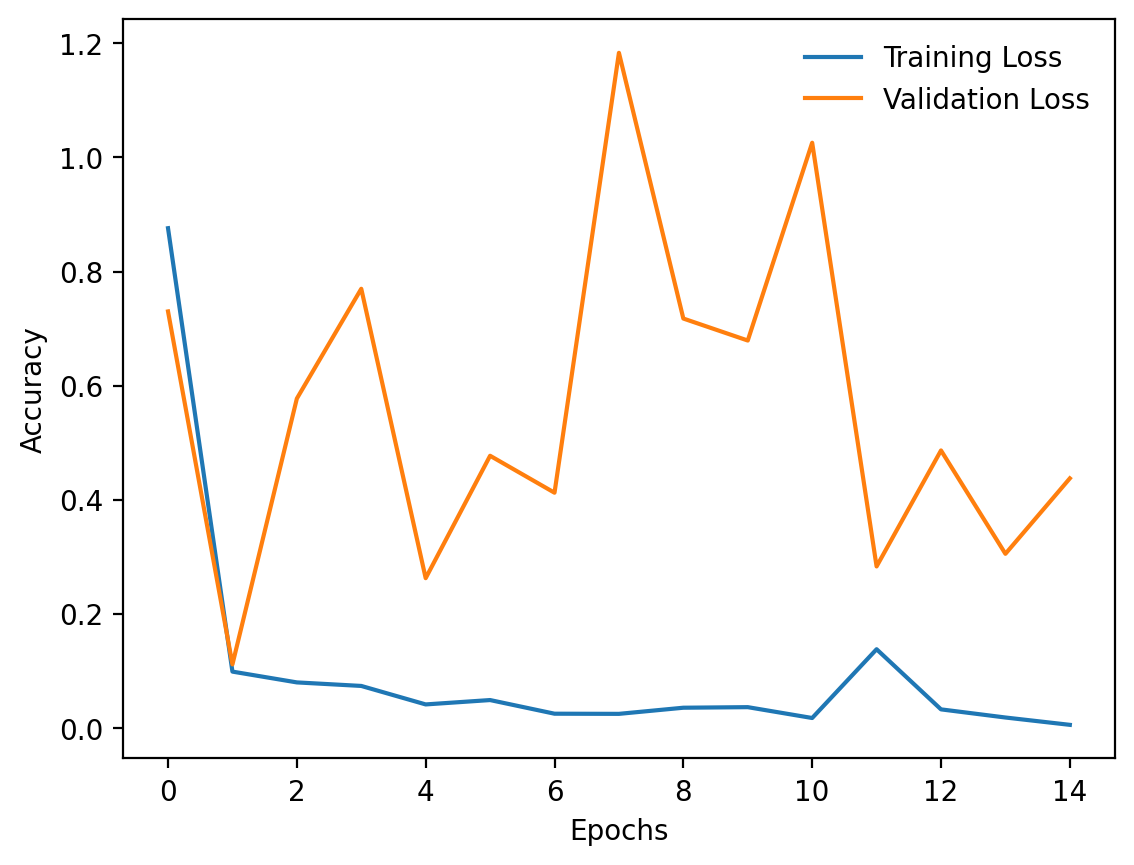

In [35]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses_vgg, label='Training Loss')
plt.plot(valid_losses_vgg, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(frameon=False)

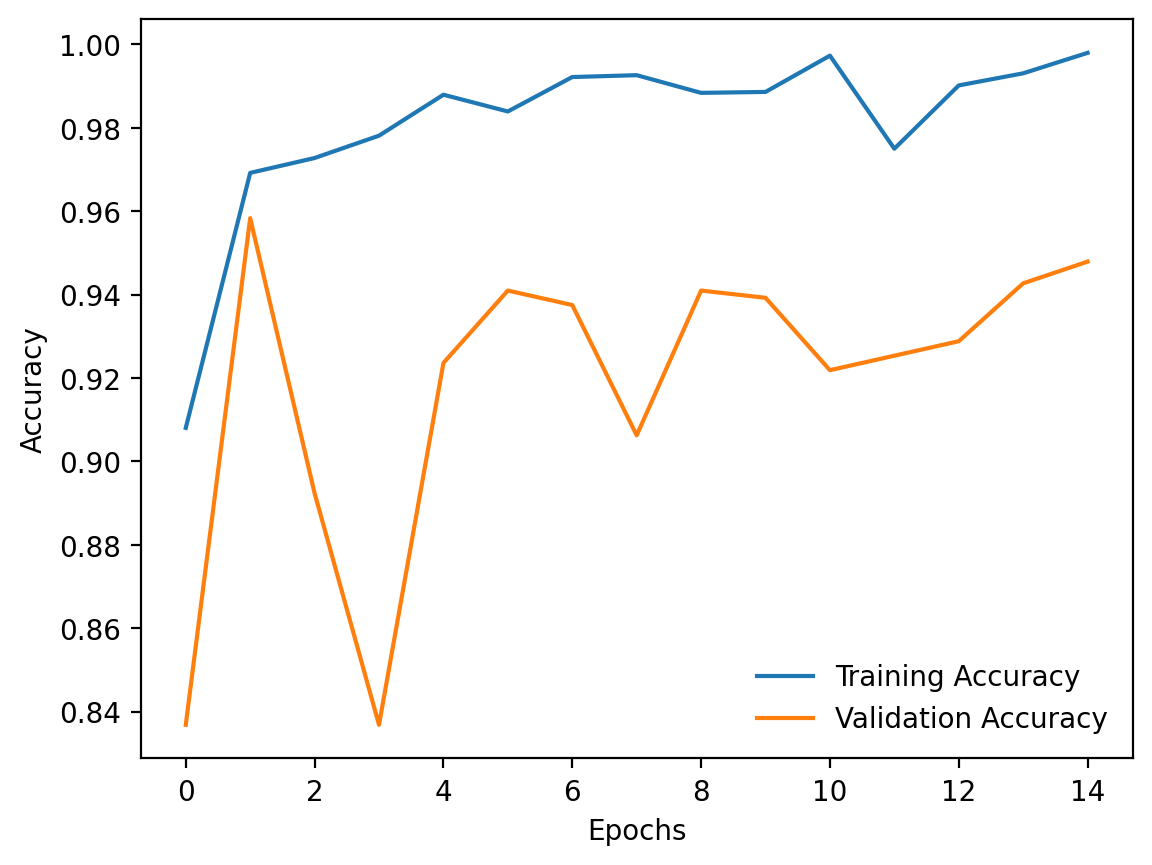

In [36]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_accuracy_vgg, label='Training Accuracy')
plt.plot(valid_accuracy_vgg, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(frameon=False)

In [37]:
(model.load_state_dicttorch.load('best-model-vgg.pt'))

<All keys matched successfully>

In [52]:
images, labels, probs = get_predictions(model, test_iter)

  0%|          | 0/20 [00:00<?, ?it/s]

In [40]:
test_df = pd.DataFrame({'id':[]})

total_cols = len(os.listdir('/content/Datasets/Pediatric Pneumonia/test'))
test_df = pd.concat([test_df,pd.DataFrame(columns=os.listdir('/content/Datasets/Pediatric Pneumonia/test'))])
# test_df.loc[len(test_df)] = 0

# if not os.path.exists('/content/Datasets/Pediatric Pneumonia/test'):
#     os.makedirs('/content/Datasets/Pediatric Pneumonia/test')
for folder in os.listdir('/content/Datasets/Pediatric Pneumonia/test'):
  for file in os.listdir('/content/Datasets/Pediatric Pneumonia/test/'+folder):
    test_df.loc[len(test_df)] = 0
    test_df.loc[len(test_df)-1, 'id'] = file
    test_df.loc[len(test_df)-1, folder] = 1
    # shutil.copy('/content/Datasets/Pediatric Pneumonia/train/'+folder+'/'+file, '/content/Datasets/Pediatric Pneumonia/test/')

test_df.sample()

,id,PNEUMONIA,NORMAL
296,person1616_virus_2802.jpeg,1,0


In [41]:
test_df.to_csv('/content/Datasets/Pediatric Pneumonia/test/pediatric-test.csv', sep=',', index=False,header=True)


In [42]:
test = pd.read_csv('/content/Datasets/Pediatric Pneumonia/test/pediatric-test.csv')
y_test = np.array(test.drop(['id'], axis=1))

[[130 260]
 [  6 228]]
[0 1]
[390 234]
[[117. 117.]
 [483. 483.]]


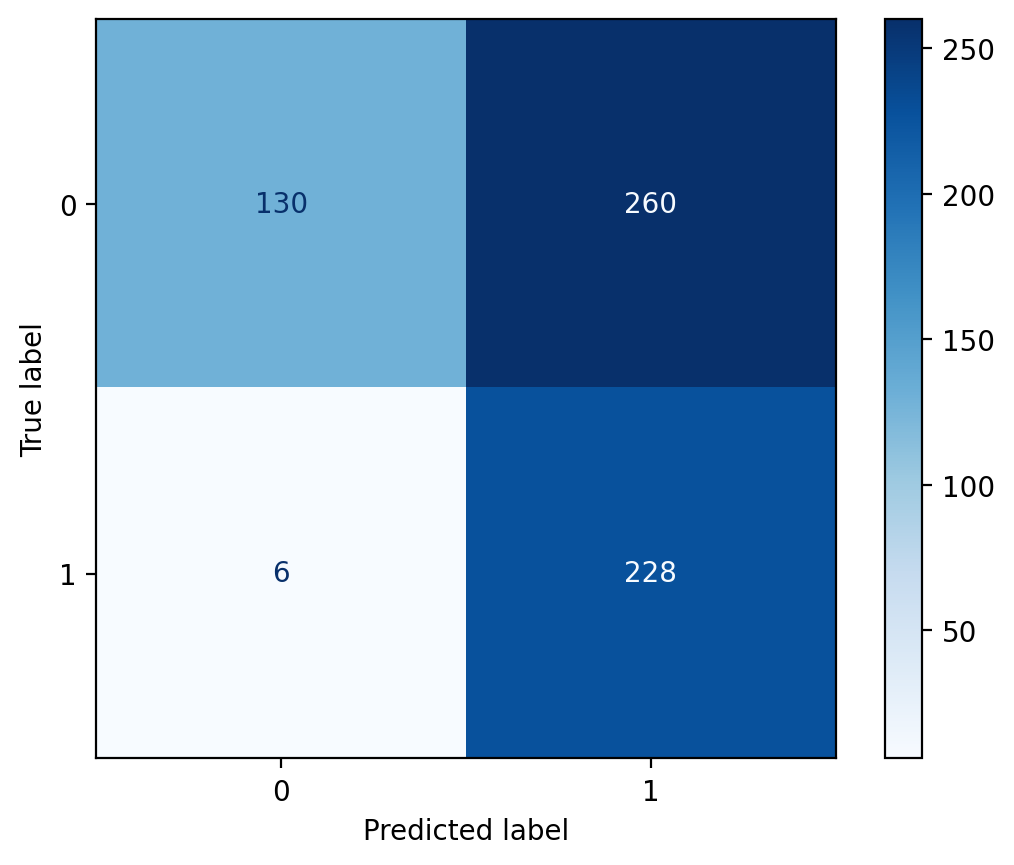

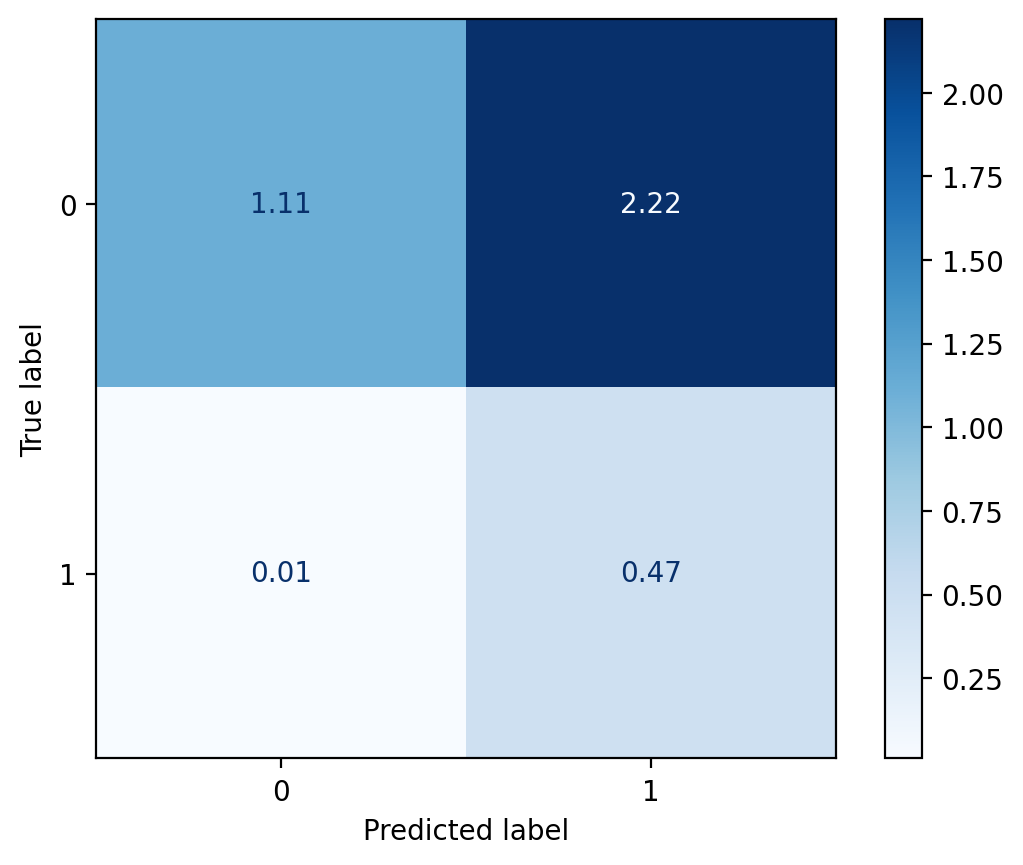

In [54]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from matplotlib.colors import Normalize
from sklearn.metrics import ConfusionMatrixDisplay

pred_class = np.argmax(probs,axis=1)
true_class = np.argmax(y_test, axis=1)

cm=confusion_matrix(true_class, pred_class)
class_names = unique_labels(true_class, pred_class)
print(cm)
print(class_names)

disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

C = cm
divisor = np.zeros((2,2))

divisor[0][:] = 117
divisor[1][:] = 483
cm_normalised=np.divide(cm, divisor)
print(np.transpose(C.sum(axis=1)))
print(divisor)
cm_normalised = np.round(cm_normalised, 2)
disp = ConfusionMatrixDisplay(cm_normalised, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='')

In [44]:
def plot_filtered_images(images, filters, n_filters=None, normalize=True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1, 2, 0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap='bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')

    fig.subplots_adjust(hspace=-0.7)

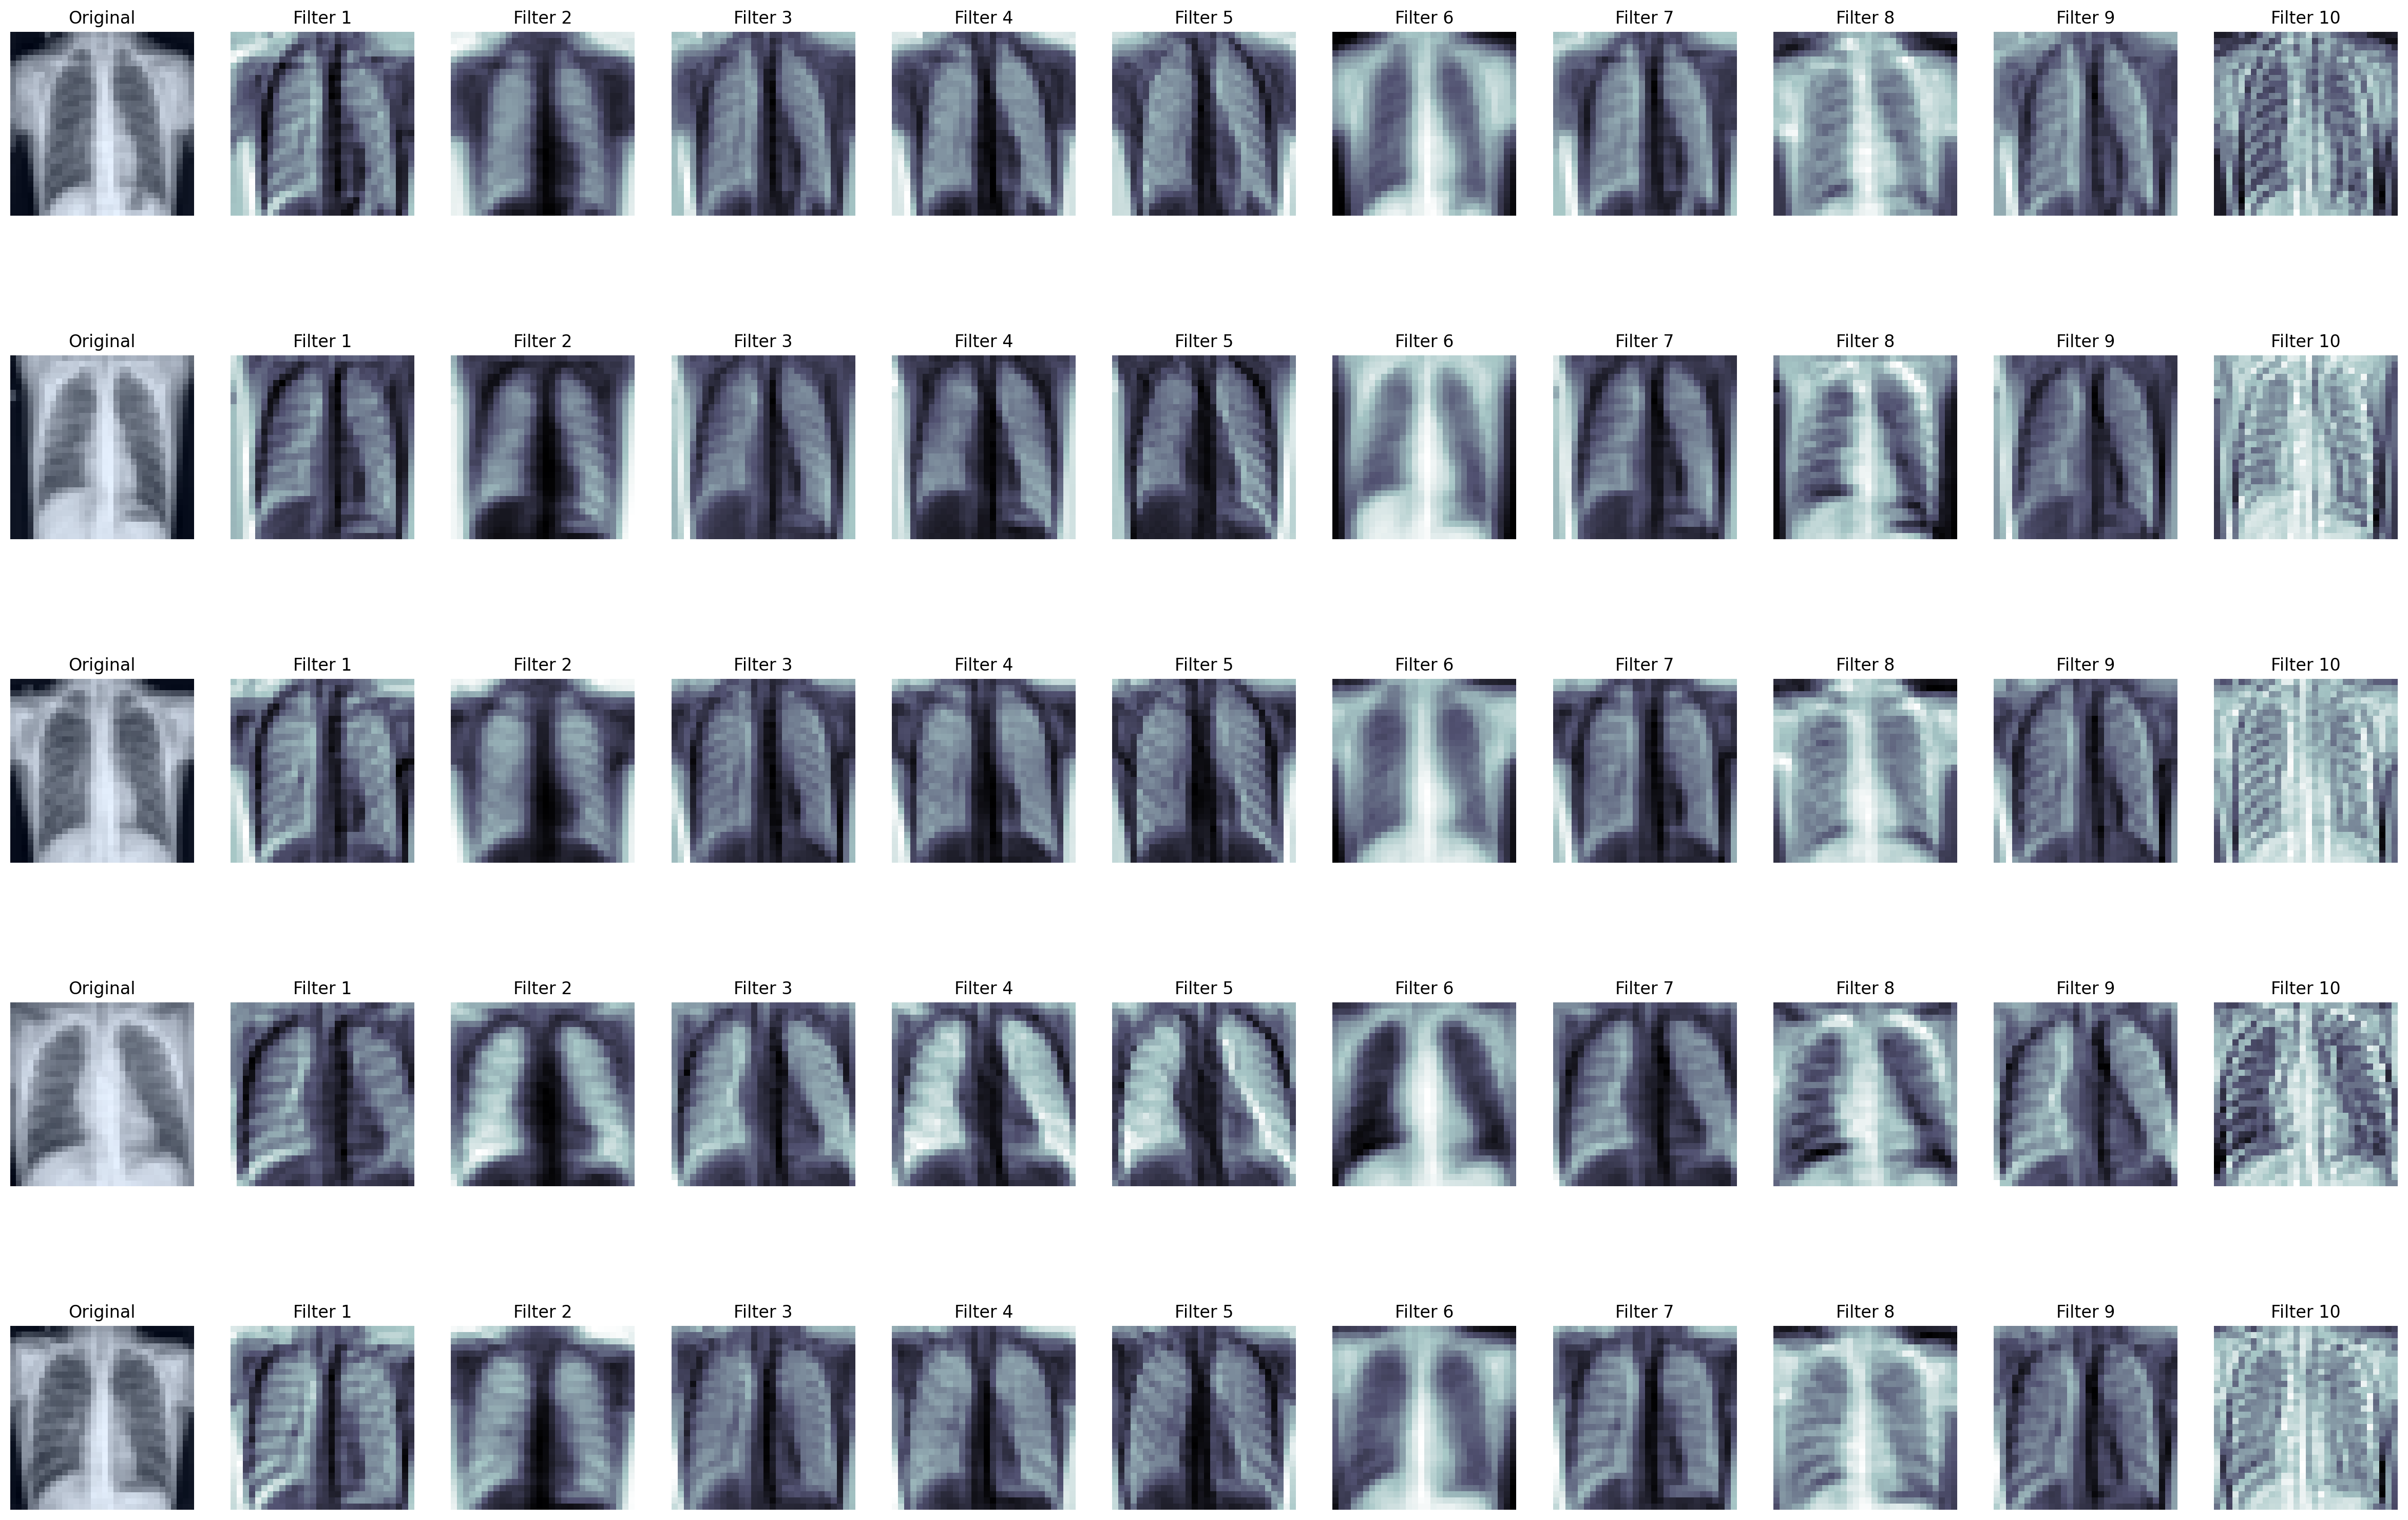

In [50]:
N_IMAGES = 5
N_FILTERS = 10

images = [image for image, label in [test_ds[i] for i in range(N_IMAGES)]]
filters = model.features[0].weight.data

plot_filtered_images(images, filters, N_FILTERS)